#  Transformer를 이용한 한국어 챗봇 생성 예제

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; 송영숙(2018)이 제시한 한국어 문장 데이터셋 『Chatbot data for Korean v1』을 사용하여 트랜스포머 챗봇 모델을 생성, 학습, 평가를 진행하였다. 트랜스포머 모델의 원리와 작동 방식과 원리 설명에 초점을 두었다. 데이터 분석, 전처리, 모델 생성 및 학습, 문장생성 능력 확인 순으로 진행하여, 최종 8,147개의 단어, 9,084개의 문장 데이터를 이용하였다. 모델 문장생성 능력 확인을 위해 '밥 먹었니?', '너 누구야?', '안녕~' 등의 문장을 입력한 결과, '배고프지 않아요.', '저는 마음을 이어주는 위로봇입니다.', '안녕하세요.' 등 상당히 자연스러운 문장을 생성하는 것을 확인하였다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제는 트랜스포머(Transformer)를 이용하여 한국어 챗봇 모델을 생성하고 모델이 그럴듯한 문장을 생성하는 것을 목표로 합니다. 모델의 개선 또는 새로운 기법의 적용보다는 '트랜스포머'의 기본적인 작동 방식과 원리를 이해하는 것에 초점을 두었습니다. 따라서, 트랜스포머의 원리를 본 예제의 작성자가 이해하는 것을 바탕으로 그림과 설명을 통해 풀어나가고자 합니다. 'RNN', 'seq2seq', 'Attention`에 대한 개념을 숙지하고 있다면 트랜스포머를 보다 쉽게 이해할 수 있을 것입니다. 예제의 진행 순서는 다음과 같습니다.
</span><br><br>


> _1. 데이터 분석_
>
> _2. 데이터 전처리_
>
> _3. 모델 생성_
>
> _4. 모델 학습 및 평가_


***

<br>

## 2. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 예제에서 사용하는 데이터는 송영숙(2018)이 제시한 『Chatbot data for Korean v1』을 이용합니다. 데이터는 질문과 대답 그리고 질문의 평상, 긍정, 부정에 대한 0에서 2사이의 값으로 이루어져 있습니다. 예제에서는 질문과 대답 데이터만을 이용합니다. 레코드 수는 총 11,823개이며 결측치는 없습니다.
</span>

***

#### 필요 라이브러리 호출
***
+ 예제에 필요한 라이브러리를 호출 합니다.
***

In [1]:
import os   #디렉토리 관리
import re   #문자열 정규식

import numpy as np   #행렬 연산
import pandas as pd   #데이터 프레임
import matplotlib.pyplot as plt   #데이터 시각화

import tensorflow as tf   #신경망
import tensorflow_datasets as tfds   #단어장 만들기

<br>

#### 데이터 불러오기
***
+ 예제에 사용하는 데이터를 불러 옵니다.


+ 질문(`Q`)과 대답(`A`) 그리고 일상(0), 부정(1), 긍정(2)의 도메인을 가지는 `label`로 구성되어 있으며 본 예제에서는 질문(`Q`)과 대답(`A`) 데이터만 이용합니다.
***

In [2]:
dataset = pd.read_csv("./dataset/transformer_chatbot/data/ChatbotData.csv")
dataset.sample(5)

,Q,A,label
3861,입 안이 다 헐었어,요즘 피곤하신가봐요.,0
501,나 비만이야,건강하게 운동해보세요.,0
949,너도 상사 있어,제가 상사예요.,0
3172,여자친구랑 전화 안 받네.,걱정되겠어요.,0
7456,이별 후 3개월이 지났는데.,여전히 힘든가봅니다.,1


#### 학습 데이터 출처
***
+ YeongSook Song, Chatbot_data_for_Korean v1.0(2018), https://github.com/songys/Chatbot_data
***

<br>

#### 레코드 수 및 결측치 확인
***
+ 레코드 수는 총 11,823개 이며, 결측치는 없습니다.
***

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


<br>

## 3. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 데이터셋을 모델에 입력하기 위해서 데이터 전처리 과정을 수행합니다. 전처리 순서는 '정규식을 이용한 문장 전처리', '단어사전 생성', '문장 길이에 따른 정제', '토크나이저화' 입니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 문장 길이를 확인한 결과, 질문에 대한 문장 분포의 최대값이 8개의 단어이며, 대답에 대한 문장 분포 최대값이 10개 였습니다. 따라서, 문장의 최대 길이를 10으로 설정하였습니다. 단어사전의 단어 수는 시작, 종료 토큰을 포함하여 총 8,147개 였으며, 앞서 설정한 문장의 최대 길이 10개의 단어에 근거하여 11개 이상의 단어로 이루어진 문장은 제외 하였습니다. 최종 9,104개의 문장을 얻었습니다. 해당 데이터를 바탕으로 자연어 문장을 정수형태로 바꾼 후 데이터셋을 생성하였습니다.
</span>

***

#### 정규식을 이용한 문장 전처리
***
+ 영문, 한글, 숫자 및 문장에서 주로 사용되는 기호를 제외한 문자는 제거 합니다.


+ 전처리가 실시된 데이터 샘플을 출력 합니다.
***

In [4]:
#전처리 함수===========================
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([0-9?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence
#End===================================


#문장 전처리===========================
questions, answers = [], []
for idx, row in dataset.iterrows():
    questions.append(preprocess_sentence(row["Q"]))
    answers.append(preprocess_sentence(row["A"]))
#End===================================


#출력부================================
print("*" * 50)
print("Question: {0} ===> {1}".format(dataset["Q"][0], questions[0]))
print("Answer: {0} ===> {1}".format(dataset["A"][0], answers[0]))
print("*" * 50)
print("Question len: {0}\tAnswer len: {1}".format(len(questions), len(answers)))
#End===================================

**************************************************
Question: 12시 땡! ===> 1 2 시 땡 !
Answer: 하루가 또 가네요. ===> 하루가 또 가네요 .
**************************************************
Question len: 11823	Answer len: 11823


<br>

#### 문장 길이 확인하기
***
+ 질문(`Question`)와 대답(`Answer`)의 문장 길이를 확인합니다.


+ 질문(`Question`)의 경우 가장 긴 문장의 길이가 16개의 단어이며, 대답(`Answer`)의 경우 24개의 단어 입니다.


+ 문장 길이의 분포(Box Plot)를 확인한 결과, 질문(`Question`)의 경우 최대값이 8개의 단어이며 대답(`Answer`)의 10개의 단어입니다.
***

************************************************************
question min len: 1
question max len: 16
question avg len: 3.9808001353294427

answer min len: 1
answer max len: 24
answer avg len: 4.720375539203248
************************************************************


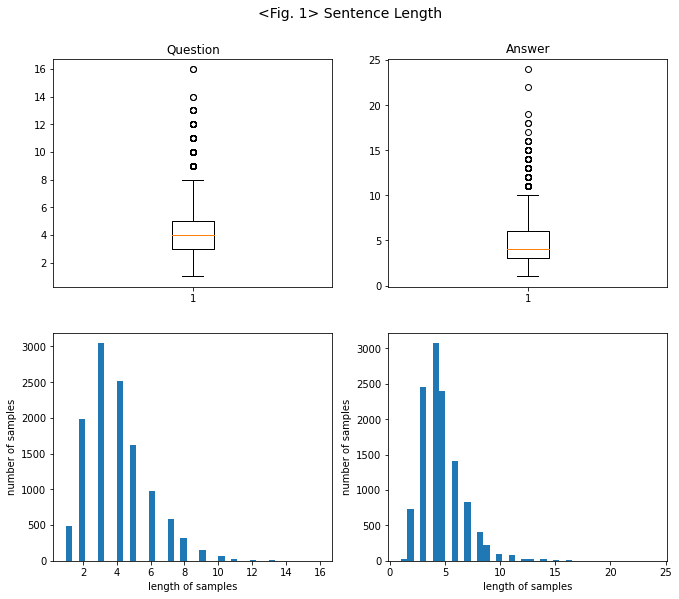

In [5]:
question_len = [len(s.split()) for s in questions]   #원문에 대한 문장 길이
answers_len = [len(s.split()) for s in answers]   #요약문에 대한 문장 길이


#출력부============================
print("*" * 60)
print('question min len: {}'.format(np.min(question_len)))
print('question max len: {}'.format(np.max(question_len)))
print('question avg len: {}'.format(np.mean(question_len)))

print('\nanswer min len: {}'.format(np.min(answers_len)))
print('answer max len: {}'.format(np.max(answers_len)))
print('answer avg len: {}'.format(np.mean(answers_len)))
print("*" * 60)
#End==============================


#시각화===========================
data_list = (question_len, answers_len)
title_list = ("Question", "Answer")

plt.figure(figsize=(11, 9))
plt.suptitle("<Fig. 1> Sentence Length", fontsize=14)
plt.subplots_adjust(top=0.9, wspace=0.2)

for idx, data in enumerate(data_list):
    idx += 1
    plt.subplot(2, 2, idx)
    
    plt.boxplot(data)
    plt.title(title_list[idx-1])
    
    plt.subplot(2, 2, idx + 2)
    plt.hist(data, bins=40)
    plt.xlabel("length of samples")
    plt.ylabel("number of samples")

plt.show()
#End==============================

<br>

#### 단어사전 생성하기
***
+ `SubwordTextEncoder`를 이용하여 단어 사전을 생성합니다.
***

In [6]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers,
    target_vocab_size=8192   #단어사전 크기
)

<br>

#### 시작, 종료 토큰 추가
***
+ 시작과 종료 토큰을 추가합니다.


+ 최종 단어사전의 크기는 8,147개 입니다.
***

In [7]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2   #시작, 종료 토큰 추가 시의 vocab 크기


#출력부================================
print("*" * 50)
print('START_TOKEN:' ,START_TOKEN)
print('END_TOKEN:' ,END_TOKEN)
print("VOCAB SIZE:", VOCAB_SIZE)
print("*" * 50)
#End===================================

**************************************************
START_TOKEN: [8145]
END_TOKEN: [8146]
VOCAB SIZE: 8147
**************************************************


<br>

#### 문장 필터링 및 토크나이저 생성
***
+ 문장의 최대 길이를 `10`으로 설정하고 그 이상의 길이에 해당하는 문장은 제외 합니다.


+ 필터링 후의 문장 수는 총 9,104개 입니다.


+ 자연어로 된 단어를 정수로 변경하여 줍니다.
***

In [8]:
MAX_LENGTH = 10

#================================
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post'
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post'
    )
    return tokenized_inputs, tokenized_outputs
#End===================================


questions, answers = tokenize_and_filter(questions, answers)


#출력부================================
print("*" * 50)
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))
print("*" * 50)
#End===================================

**************************************************
필터링 후의 질문 샘플 개수: 9084
필터링 후의 답변 샘플 개수: 9084
**************************************************


<br>

#### 데이터셋 생성하기
***
+ 앞서 획득한 9,104개의 정수화된 문장 데이터를 데이터셋으로 만듭니다.


+ 배치 사이즈는 64개로 설정 합니다.


+ 지금까지 자연어로 된 문장을 정수 형태로 된 데이터셋으로 만드는 과정이 이루어졌습니다.
***

In [9]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

#데이터셋 생성=============================================
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        #마지막 글자 제외 = END TOKEN 제외
        'dec_inputs': answers[:, :-1]
    },
    {
        #첫 번째 글자 제외 = START TOKEN 제외
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
#End=========================================================


#출력부======================================================
for input_data, output_data in dataset.take(1): break;
rand_idx = np.random.randint(0, BATCH_SIZE)
seq = input_data["inputs"][rand_idx]

print("*" * 70)
for word in seq.numpy():
    try:
        word = tokenizer.subwords[word - 1]
        if word == " , ,": break;
        print(word, end="")
    except:
        pass
print("\n" + "↓" * 35)
print(seq.numpy())
print("*" * 70)
#End=========================================================

**********************************************************************
보조_배터리안_가지고_왔다
↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
[8145  187 6236 5312 7921   20  938 1092 8146    0]
**********************************************************************


<br>

## 4. 트랜스포머 모델 생성
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 트랜스포머 모델은 크게 인코더 부분과 디코더 부분으로 이루어져 있습니다. 모델의 목표는 'seq2seq'의 '시계열 데이터를 입력하여 시계열 데이터를 얻는 것'과 동일합니다. 기본적인 아이디어는 'Attention'만을 이용하여 'seq2seq'를 수행 하는 것입니다. 또한, 기존의 'Attention'은 RNN을 이용하여 데이터의 입력이 '순차적'으로 수행되었지만, 트랜스포머의 데이터 입력은  '동시에' 혹은 '병렬적'으로 수행된다는 특징이 있습니다. 구체적인 트랜스포머의 작동 원리와 모델 생성 과정을 설명하고자 합니다.
</span>

***

### 4.1. Positional 인코딩 레이어
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Positional 인코딩 레이어는 문장을 이루고 있는 단어들의 순서를 모델에게 알려주기 위해 사용 됩니다. Positional 인코딩 레이어의 필요성과 구체적인 사용 방법에 대해 설명하겠습니다.
</span>

***

### 4.1.1. Positional 인코딩 레이어의 존재 이유
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 트랜스포머는 데이터의 입력이 병렬적으로 이루어진다고 하였습니다. 이를 쉽게 설명한다면 '문장을 동시에 한 번에 넣는 것'이라고 할 수 있습니다. [그림 2]는 기존 RNN을 이용한 seq2seq의 데이터 입력 방식과 트랜스포머의 입력 방식을 그린 것입니다. 
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; RNN을 이용한 경우에는 'I', 'Love', 'You' 단어를 RNN 유닛에 단어별로 순차적으로 넣어주었습니다. 하지만 트랜스포머에서는 단어를 하나의 행렬로 묶어 한 번에 입력합니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 여기서 문제가 발생하는데, RNN의 경우에는 단어를 순차적으로 입력하기 때문에 모델이 단어의 순서를 알 수 있습니다. 하지만, 트랜스포머의 경우 동시에 입력되기 때문에 단어의 순서를 알 수 없습니다. 한 문장에 동일한 단어가 존재할 때, 두 단어의 임베딩 벡터 값은 동일할 것이고 모델은 그 순서를 알 수 없습니다. 이러한 문제를 해결하기 위해 Positional 인코딩 레이어가 사용됩니다.
</span>

<img src="./img/why_positional.png" width=400>
[그림 2] 기존 seq2seq의 작동 방식과 트랜스포머의 작동 방식

***

### 4.1.2. 구체적인 Positional 인코딩 레이어의 활용 방법
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Positional 인코딩 레이어는 단어별 즉, 행별로 다른 값을 가지는 레이어와 입력되는 단어 임베딩을 더하여 그 순서를 구분하고자 합니다. [그림 3]은 Positional 인코딩 레이어를 통해 어떻게 순서를 구분하는지 보여줍니다. 'sentence length'는 문장의 길이 즉, 문장을 이루는 단어의 개수 입니다. 'word vector'는 단어 임베딩 벡터의 차원 수 입니다. 따라서, Posltional 인코딩 레이어의 각 행이 단어이며 그 순서를 나타내는 것입니다. 따라서 1행은 t 시점의 단어, 2행은 t + 1 시점의 단어에 해당하는 것입니다. 따라서, 각 행별로 다른 값을 가진 Positional 인코딩 레이어와 입력되는 단어 임베딩을 더하면 같은 단어라도 출력되는 값이 달라지게 됩니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Positional 인코딩 레이어와 입력되는 문장 행렬은 같은 위치의 원소를 더하는 것이기 때문에 두 행렬의 크기는 동일함을 알 수 있습니다. Positional 인코딩 레이어의 패턴은 Cosin과 Sin을 이용합니다. 중요한 것은 단어에 해당하는 각 행의 값이 모두 다른 점을 이용하여 단어의 순서를 구분한다는 것입니다.
</span>

<img src="./img/positional.png" width=500>
[그림 3] Positional 인코딩 레이어와 연산 방식

***

<br>

#### Positional 인코딩 레이어 생성
***
+ Positional 인코딩 레이어를 생성합니다.
***


In [10]:
# 포지셔널 인코딩 레이어++++++++++++++++++++++++++++++++++++++++++++++++++++++
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        #position: 행 크기(=문장 길이), d_model:  임베딩 차원
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    #(pos / 10000 ** 2i / d_model)==============================
    def get_angles(self, position, i, d_model):
        #tf.pow(x, y): x ** y
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    #End========================================================
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)   #순차대로 적재
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):   #input과 positional encoding과 합치기
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
#End++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

<br>

#### 포지셔널 인코딩 레이어 시각화
***
+ 임베딩 크기는 512이며, 문장 길이는 10인 Positional 인코딩 레이어를 시각화 합니다.


+ 각 행별로 그 값이 다른 것을 확인할 수 있습니다.
***

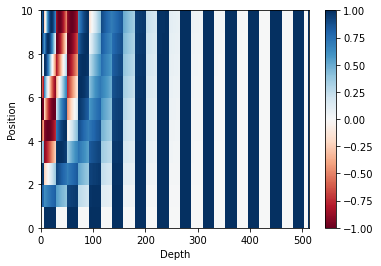

In [11]:
EMBEDDING_SIZE = 512

sample_pos_encoding = PositionalEncoding(MAX_LENGTH, EMBEDDING_SIZE)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, EMBEDDING_SIZE))
plt.ylabel('Position')
plt.colorbar()
plt.show()

<br>

#### 중복 행 여부 확인하기
***
+ Positional 인코딩 레이어의 행 중 중복되는 행을 제거하여 그 크기 변화를 확인합니다.


+ 그 결과, 제거된 행이 없으며, 이는 중복되는 행이 없음을 의미 합니다.
***

In [12]:
print("*" * 50)
print(sample_pos_encoding.pos_encoding.shape)
print("↓↓↓↓↓drop duplicate data↓↓↓↓↓")

#중복행 제거
test_pd = pd.DataFrame(sample_pos_encoding.pos_encoding.numpy()[0]).copy()

print(test_pd.drop_duplicates(test_pd.columns.tolist()).shape)
print("*" * 50)

**************************************************
(1, 10, 512)
↓↓↓↓↓drop duplicate data↓↓↓↓↓
(10, 512)
**************************************************


<br>

### 4.2. Scaled Dot Product Attention
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Scaled Dot Product Attention은 Attention의 일종으로 단어 벡터 간 유사도를 행렬곱(Product)하고 정규화(Scale)한 것으로 이해할 수 있습니다. 우선 Attention을 설명한 후, Scaled Dot Product Attention을 구하는 방법을 설명하고자 합니다.
</span>

***

### 4.2.1. Attention의 역할
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Attention은 문장의 단어 간 연관 정도를 파악하는 것입니다. 그리고 연관도가 높은 단어에 집중(Attetion)하겠다는 것입니다. [그림 4]는 Atention을 도식화 한 것입니다. 'I am a boy'에서 'I'와 각 단어의 연관도를 파악한다면, '나'는 '남자'이기 때문에 'boy'와 높은 연관도를 가질 것입니다. 이러한 단어 간의 연관도는 모델이 문장을 이해하는데 도움을 줍니다. 단어의 연관도는 [그림 3]과 같이 행렬 형태로 나타내어 연산이 이루어 집니다.
</span>

<img src="./img/what_attention.png" width=500>

***

### 4.2.2. Scaled Dot Product Attention 연산
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 구체적인 Scaled Dot Product Attention을 구하는 방법을 알아보겠습니다. 이를 구하기 위해서는 Query(Q), Key(K), Value(V), d가 이용됩니다. Query는 비교하고자 하는 단어의 벡터들, Key와 Value는 비교되는 단어의 벡터들입니다. d는 정규화를 위한 하나의 스칼라 값입니다. 단어 벡터의 크기를 병렬 수행할 수(Num Head)로 나누어 줍니다. [그림 5]는 Scaled Dot Product Attention의 연산 순서를 제시한 것입니다.
</span><br><br>
    
    
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 연산은 비교하고자 하는 단어의 벡터들(Q)와 비교 대상이 되는 단어의 벡터들의 전치행렬(K)을 행렬곱(Dot Product) 해준 후, 이를 sqrt(d)로 나누어 줍니다. 이후 Value를 곱하여 줍니다. 각 Q, K, V의 크기는 모두 동일하며, 해당 크기는 단어 벡터의 크기를 병렬 수행할 수(Num Head)로 나눈 값을 이용합니다. 논문에서는 512 크기의 단어 벡터와 8개의 Num Head를 이용하여 Q, K, V의 크기가 64입니다. 또한, Scaled Dot Product Attention 연산의 최종 출력 또한 Q, K, V와 크기가 동일한 것을 확인할 수 있습니다. [그림 5]에는 나와 있지 않지만 최종적으로 얻은 Scaled Dot Product Attention 값을 Dense 레이어에 통과 시킵니다. 아래는 Scaled Dot Product Attention의 수식을 제시한 것입니다.
</span><br><br>

$$Attention(Q, K, V) = softmax(\frac{QK^T}{sqrt(d_k)}) V$$

<br><img src="./img/scaled_dot.png" width=800>

[그림 5] Scaled Dot Product Attention 연산 순서
***

<br>

#### Scaled Dot Product Attention 함수 생성
***
+ Scaled Dot Product Attention 연산을 수행하는 함수를 생성 합니다.
***

In [13]:
#스케일드 닷 프로덕트 어텐션 함수(Q, K, V, mask)===============
def scaled_dot_product_attention(query, key, value, mask):
    #Q ·K product
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)   #depth=d_k
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    #Key에서 패딩열에 아주 작은 값으로 대체한다.
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output
#End===========================================================

<br>

#### 패딩 마스크 생성하기
***
+ 어텐션에서 `패딩(padding)`에 대한 유사도는 불필요하기 때문에 패딩열의 값을 작은 값으로 대체하여 softmax 출력에서 0의 확률이 나오도록 유도


+ 패딩 위치를 `1(True)`로 출력하는 함수
***

In [14]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

<br>

### 4.2.3. Query, Key, Value의 근원
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Query, Key, Value는 어떻게 구하는지 알 필요가 있습니다. [그림 6]은 Query, Key, Value를 구하는 방법을 보여줍니다. 우선 앞서 설명한 Positional 인코딩 레이어와 문장 행렬이 더해진 값이 입력 됩니다. [그림 6]에서는 이해를 위해 행 크기를 1로 설정하였습니다. 행 크기가 1이란 것은 단어가 한 개만 입력된 것으로 생각할 수 있습니다. 그럼 이는 Wq, Wk, Wv 총 세 개의 Dense 레이어를 통과 합니다. Dense 레이어는 임베딩 벡터의 크기와 동일한 수의 유닛을 가집니다. 그럼이를 Num Head의 크기에 맞게 형태를 변형합니다. 논문에서는 512의 임베딩 벡터를 8개의 Num head로 나누어 8 x 64로 변형 하였습니다. 최종적으로 각 행이 Query, Key, Value에 해당하며, 총 8개의 Head가 생성된 것을 확인할 수 있습니다.
</span>

<img src="./img/get_qkv.png" width=800>

[그림 6] Query, Key, Value 획득 방법

***

#### Multi Head Attention 정의
***
+ 앞서 설명한 Head 나누기와 Scaled Dot Product Attention을 결합하여 Multi Head Attention 레이어를 정의 합니다.
***

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):
    #d_model: 단어 벡터 크기, num_heads: 병렬 처리 개수
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        #assert 문이 False이면 assert 에러 발생
        #assert는 에러문이 발생하지만, 코드가 중단되지는 않는다.
        #즉 단어 벡터 크기가 병렬 처리 개수로 나누었을 때,
        #맞아 떨어져야 잘 작동한 다는 뜻이다.
        assert d_model % self.num_heads == 0

        #하나의 head가 가지는 벡터 크기
        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            #shape(batch_size, MAX_LENGTH, num_heads, depth)
            #=(64, 40, 8, 64)
            inputs, shape=(batch_size, -1, self.num_heads, self.depth)
        )
        #shape(batch_size, num_heads, MAX_LENGTH, depth)
        #=(64, 8, 40, 64)
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        
        # 병렬 연산을 위한 머리를 여러 개 만듭니다+++++++++++
        #num_head 수 만큼 나누기
        #shape(batch_size, num_heads, MAX_LENGTH, depth)
        #=(64, 8, 40, 64)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        #End+++++++++++++++++++++++++++++++++++++++++++++++++
        

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        #shape(batch_size, MAX_LENGTH, num_heads, depth)
        #=(64, 40, 8, 64)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(
            scaled_attention,
            #shape(batch_size, MAX_LENGTH, (num_heads, depth))
            #=(64, 40, 512)
            (batch_size, -1, self.d_model)
        )

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

<br>

### 4.3. 인코더 레이어
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 설명한 Multi Head Attention을 활용하여 인코더 레이어를 정의할 수 있습니다. 결국 Multi Head Attention은 설정한 Head의 수만큼 단어 간의 연관도를 계산하는 것입니다. 또한 입력과 출력의 크기가 동일하다는 것도 설명하였습니다. 입력과 출력의 크기가 동일하기 때문에 인코더 레이어를 여러 층 쌓는 것이 가능합니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 인코더 레이어의 형태는 앞서 설명한 Multi Head Attention 후에 Position-wise 피드 포워드 층이 오는데 피드 포워드 층은 흔히 알고 있는 Dense 층으로 이해할 수 있습니다. [그림 7]은 인코더 레이어의 아키텍처를 제시한 것입니다.
</span>

<img src="./img/encoder.png" width=500>

[그림 7] 인코더 레이어의 아키텍처

***

#### 인코더 레이어 정의
***
+ 인코더 레이어를 정의합니다.
***

In [16]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        }
    )

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name
    )

<br>

### 4.4. 인코더 통합
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 이제 트랜스포머의 인코더 파트를 정의할 수 있습니다. 전체적으로 다시 설명하겠습니다. [그림 8]은 트랜스포머의 인코더 파트를 제시한 것입니다. 트랜스포머의 입력은 단어를 묶어 한번에 입력(Input) 합니다. 단어를 묶는다는 것은 결국 '문장을 한 번에 넣는다'라고 이해할 수 있습니다. 이는 임베딩 레이어를 통과하여 임베딩 벡터의 묶음, 행렬로 변환 됩니다. 단어의 순서를 적용하기 위해 Positional 인코딩을 추가하여 줍니다. Multi Head Attention에 입력하여 줍니다. 단어의 연관도를 구할 때, Padding의 연관도는 불필요하므로 padding mask도 함께 입력하여줍니다. 인코더 레이어는 여러 개를 쌓을 수 있으며, 논문에서는 6개의 인코더 레이어를 사용하였습니다. 최종 출력은 이후 디코더에 입력됩니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 트랜스포머 인코더 파트의 중요한 부분은 역시 Multi Head Attention이 사용되는 인코더 레이어일 것입니다. 입력되는 문장의 단어 간의 연관도를 구한다는 것. 그리고 인코더 파트의 Attention은 입력되는 하나의 문장에서 사용된 단어 간의 연관도를 구합니다. 따라서 'Self-Attention' 이라고 불리는 것입니다.
</span>

<img src="./img/encoder_arch.png" width=500>

[그림 8] 트랜스포머의 인코더

***

#### 인코더 통합하기
***
+ 앞서 정의한 레이어를 통합하여 트랜스포머의 인코더 파트를 정의 합니다.
***

In [17]:
def encoder(
    vocab_size,
    num_layers,
    units,
    d_model,
    num_heads,
    dropout,
    name="encoder"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
    inputs=[inputs, padding_mask], outputs=outputs, name=name
    )

<br>

### 4.4. 인코더와 디코더 연결 부분
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서, 트랜스포머의 인코더를 설명하였습니다. 이번에는 인코더의 출력이 어떻게 활용되는지 설명하겠습니다. [그림 9]는 트랜스포머의 인코더와 디코더를 간략화한 것입니다. 결론만 말하자면 인코더의 최종 출력 중 Key와 Value가 디코더의 Multi Head Attention에 입력 됩니다. 이것이 의미하는 것은, 디코더에 입력된 단어 벡터들(Query)과 인코더로부터 입력된 단어 벡터들(Key, Value)의 연관도를 구한다는 것입니다. 'seq2seq'에 대입하여 설명하자면, 인코더로부터 입력되는 정보(Key, Value)는, 인코더의 정보가 함축된 Context vector에 해당한다고 할 수 있습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 또한, 앞서 설명한 인코더의 Multi Head Attention은 입력된 하나의 문장 내의 단어 간 연관도를 구하였지만, 해당 Attention은 인코더에 입력된 단어들과 디코더에 입력된 단어들을 비교하는 것입니다. 그렇기 때문에 Self가 붙지않는 것을 확인할 수 있습니다.
</span>

<img src="./img/connect_enc_dec.png" width=500>

[그림 9] 트랜스포머의 인코더와 디코더

***

### 4.5. Multi Head Attention
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 디코더의 Multi Head Attention에 대해 조금 더 하겠습니다. [그림 10]은 디코더의 Multi Head Attention 연산을 간략화 한 것입니다. 앞서 배운 것과 마찬가지로 softmax, 정규화 과정 모두 동일하지만 설명을 위해 Query, Key, Value 행렬만 시각화 하였습니다. 예제의 목표는 챗봇 이기 때문에 'I love you'라는 문장을 넣으면 'Me too'라는 문장을 출력하도록 학습한다고 가정해 보겠습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 인코더에 'I love you'입력하였습니다. 이에 대한 Key, Value가 디코더로 넘어옵니다. 우리가 원하는 것은 이에 대해 'Me too'라고 대답하는 것입니다. 따라서 'I love you'와 '&lt;SOS> Me too'의 연관도를 구합니다. 즉, 한 문장 내의 단어 간 연관도를 구한 것이 아니라 다른 문장의 단어와의 연관도를 구하는 것입니다.
</span>

<img src="./img/dec2layer.png" width=500>

[그림 10] 디코더의 Multi Head Attention 연산

***

<br>

### 4.6. Look Ahead Mask
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 트랜스포머 디코더의 학습은 '교사강요'로 인해 target 문장이 그대로 들어갑니다. 이에따라 한 가지 문제가 발생합니다. [그림 11]은 학습 시 디코더에 입력되는 target 문장을 보여줍니다. 'I love you'라고 대답하도록 학습 시키기위해 해당 문장을 디코더에 입력합니다. 우리가 원하는 것은 모델이 I를 바탕으로 love를 예측하고 다음 'I love'를 바탕으로 You를 예측하는 것입니다. 하지만 문장이 그대로 입력되었기 때문에 답을 보고 대답하는 것과 마찬가지 입니다. 따라서, 이를 방지하기 위해 현재 시점 이후의 단어를 가려줄 필요가 있습니다. 그리고 이를 위한 기법이 바로 Look Ahead Mask 입니다.
</span>

<img src="./img/why_lock.png" width=500>

[그림 11] 학습 시 동시에 입력되는 데이터

***

#### Look Ahead Mask 정의
***
+ Look Ahead Mask 정의하여 줍니다.
***

In [18]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

<br>

### 4.7. 디코더 레이어
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 디코더 레이어를 정의합니다. [그림 12]는 디코더 레이어의 아키텍처를 시각화 한 것입니다. 디코더 레이어의 특징은 Atetnion이 두 번 사용된다는 것입니다. 이를 간단히 설명하자면, 먼저 디코더에 입력되는 문장 내의 단어 간 연관도를 구하는 'Self Attention'을 수행하고 이를 바탕으로 질문에 대한 문장과 디코더 즉, 대답에 대한 문장 단어 간의 연관도를 구하는 Attention을 수행하는 것입니다. 충분히 논리적인 구성이라 생각됩니다. 이후 인코더 레이어와 마찬가지로 FFNN이 오게 됩니다.
</span>

<img src="./img/decoder.png" width=600>

[그림 12] 디코더 레이어 아키텍처

***

#### 디코더 레이어 정의
***
+ 디코더 레이어를 정의 합니다.
***

In [19]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask"
    )
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6
    )(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6
    )(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6
    )(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )

#### 디코더 정의하기
***
+ 앞서 정의한 레이어를 이용하여 트랜스포머의 디코더를 정의 합니다.
***

In [20]:
def decoder(
    vocab_size,
    num_layers,
    units,
    d_model,
    num_heads,
    dropout,
    name='decoder'
):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask'
    )

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )

<br>

### 4.9. Transformer 정의
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞에서 정의한 트랜스포머의 인코더와 디코더를 통합하여 최종적으로 트랜스포머 모델을 정의합니다. [그림 13]은 트랜스포머 모델을 시각화 한 것입니다. 디코더에서는 최종적으로 단어사전 크기의 레이어를 통과한 후 softmax를 통해 단어의 확률분포를 출력합니다. 인코더와 디코더를 확인할 수 있고 앞에서 설명한 인코더와 디코더의 연결 형태, Look Ahead Mask 등을 확인할 수 있습니다. 인코더와 디코더는 총 2개를 이용하였으며, 임베딩 크기는 256, Head의 수는 8로 설정하였습니다.
</span><br><br>

<img src="./img/transformer_arch.png" height=650>

[그림 13] 트랜스포머 아키텍처

***

#### 인코더 디코더 통합하기
***
+ 인코더와 디코더를 통합하여 트랜스포머 모델을 정의합니다.
***

In [21]:
def transformer(
    vocab_size,
    num_layers,
    units,
    d_model,
    num_heads,
    dropout,
    name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask'
    )(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None), name='look_ahead_mask'
    )(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask'
    )(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

<br>

#### 모델 생성하기
***
+ 최종적으로 모델을 생성합니다.
***

In [22]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3139840     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

<br>

## 5. 모델 학습 및 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; input_text
</span>

***

### 5.1. 모델 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 생성한 트랜스포머 모델을 학습하기위해 '손실함수 정의', '학습률 정의', '컴파일 정의' 과정을 수행 합니다. 손실함수는 패딩을 고려하여 마스크를 추가해주어 함수를 정의 합니다. 학습률은 고정하지 않고 학습 진행에 따라 변경되도록 합니다. 옵티마이저는 Adam을 이용하여 총 25epoch 학습을 진행합니다.
</span>

***

#### 손실함수 정의하기
***
+ 패딩을 제외한 단어에 대한 손실함수를 정의 합니다.
***

In [23]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none'
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    #패딩이 아닌 단어만 살리기
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

<br>

#### 학습률 정의하기
***
+ 학습 진행 시에 학습률을 동일하게 적용하지 않고 진행 정도에 따라 학습률을 변경 합니다.
***

Text(0.5, 0, 'Train Step')

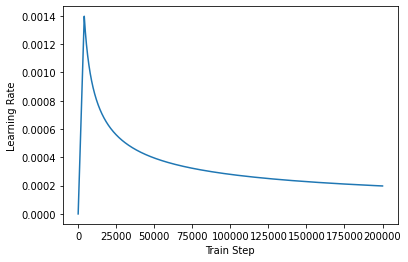

In [24]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
    
#시각화=====================
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
#End========================

<br>

#### 컴파일 정의하기
***
+ 옵티마이저는 Adam을 이용하고 앞서 정의한 손실함수를 사용합니다.
***

In [25]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

<br>

#### 모델 학습하기
***
+ Epoch를 25로 설정하고 학습을 진행합니다.
***

In [26]:
EPOCHS = 25
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/25
142/142 [==============================] - 16s 63ms/step - loss: 5.8243 - accuracy: 0.0443
Epoch 2/25
142/142 [==============================] - 9s 62ms/step - loss: 4.9009 - accuracy: 0.2075
Epoch 3/25
142/142 [==============================] - 9s 62ms/step - loss: 4.0714 - accuracy: 0.2147
Epoch 4/25
142/142 [==============================] - 9s 62ms/step - loss: 3.5545 - accuracy: 0.2172
Epoch 5/25
142/142 [==============================] - 9s 61ms/step - loss: 3.3298 - accuracy: 0.2280
Epoch 6/25
142/142 [==============================] - 9s 61ms/step - loss: 3.1248 - accuracy: 0.2393
Epoch 7/25
142/142 [==============================] - 9s 62ms/step - loss: 2.9396 - accuracy: 0.2532
Epoch 8/25
142/142 [==============================] - 9s 62ms/step - loss: 2.7122 - accuracy: 0.2743
Epoch 9/25
142/142 [==============================] - 9s 61ms/step - loss: 2.4850 - accuracy: 0.3050
Epoch 10/25
142/142 [==============================] - 9s 62ms/step - loss: 2.2163 - accur

<br>

### 5.1. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 학습한 트랜스포머 모델의 문장 생성 능력을 확인합니다. [그림 14]는 트랜스포머의 입력에 대한 문장 생성 과정을 제시한 것입니다. '너 누구야?'라는 문장과 '&lt;SOS>'를 인코더와 디코더에 입력하면 단어 사전의 확률분포를 출력하고 그 중 높은 단어 채택합니다. [그림 14]에서는 '나'가 출력되었습니다. 그럼 '&lt;SOS>'와 '나'를 합친 후, 다시 '너 누구야?'라는 문장과 '&lt;SOS> 나'를 인코더와 디코더에 입력합니다. 그러한 과정을 설정한 문장의 최대 길이 만큼 수행하거나 종료 토큰이 출력될 때까지 반복 합니다.
</span><br><br>

<img src="./img/how_predict.png" width=400>

[그림 14] 트랜스포머의 문장생성 과정

***

#### 문장 생성 과정 함수 생성
***
+ 모델에 문장을 입력하였을 때, 문장을 생성하는 과정을 함수로 생성합니다.
***

In [32]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)   #정규식을 이용한 전처리

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
    )

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

<br>

#### 정수 문장을 자연어 문장으로 변환하는 함수 생성
***
+ 모델이 출력한 정수로된 문장을 자연어 문장으로 변환하는 함수를 생성합니다.
***

In [39]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )

    print('입력 : {}'.format(sentence))
    return ('출력 : {}'.format(predicted_sentence))

<br>

#### 문장 생성 확인하기
***
+ 모델의 문장 생성 능력을 확인한다.
***

In [40]:
print("*" * 50)
print(sentence_generation('밥 먹었니?'), end="\n\n")
print(sentence_generation('너 누구야?'), end="\n\n")
print(sentence_generation('안녕~'), end="\n\n")
print(sentence_generation('여행가자'), end="\n\n")
print(sentence_generation('사랑이 뭐야?'), end="\n\n")
print("*" * 50)

**************************************************
입력 : 밥 먹었니?
출력 : 배고프지 않아요 .

입력 : 너 누구야?
출력 : 저는 마음을 이어주는 위로봇입니다 .

입력 : 안녕~
출력 : 안녕하세요 .

입력 : 여행가자
출력 : 계획을 세워보세요 .

입력 : 사랑이 뭐야?
출력 : 신뢰이자 믿음이라고 생각해요 .

**************************************************


<br>

## 6. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서는 트랜스포머 챗봇 모델을 생성, 학습하고 모델의 문장생성 능력을 확인하였습니다. 한국어 문장 데이터를 이용하였으며, 8,147개의 단어와 9,084개의 문장을 바탕으로 모델을 학습하였습니다. 모델의 문장생성 능력을 확인하기 위해 '밥 먹었니?', '너 누구야?', '안녕~' 등의 문장을 입력한 결과, '배고프지 않아요.', '저는 마음을 이어주는 위로봇입니다.', '안녕하세요.' 등 상당히 자연스러운 문장을 생성하였습니다. 다음은 입력한 문장과 그에 대한 모델이 생성한 문장을 제시한 것입니다.
</span><br><br>


> ___Q: 밥 먹었니?___
>
> ___A: 배고프지 않아요.___


> ___Q: 너 누구야?___
>
> ___A: 저는 마음을 이어주는 위로봇입니다.___


> ___Q: 안녕~___
>
> ___A: 안녕하세요.___


> ___Q: 여행가자___
>
> ___A: 계획을 세워보세요.___


> ___Q: 사랑이 뭐야?___
>
> ___A: 신뢰이자 믿음이라고 생각해요.___

***

#### 형상관리 기록
***
+ v1_1: 초기모델


+ v1_2: 제출 예제 진행


+ v2_1: 코드 단위 분석


+ v3_1: 문장 길이 분석
***